In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [54]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/merged_books_with_images.csv")

df.columns

Index(['book_id', 'isbn', 'text_reviews_count_x', 'series', 'popular_shelves',
       'average_rating_x', 'similar_books', 'description', 'authors',
       'publisher', 'num_pages', 'isbn13', 'ratings_count_x', 'work_id',
       'title', 'user_id', 'review_id', 'rating', 'review_text', 'author_id',
       'average_rating_y', 'text_reviews_count_y', 'name', 'ratings_count_y',
       'genres', 'most_popular_genre', 'image_url'],
      dtype='object')

In [55]:
tqdm.pandas(desc="Veri Temizleme")
df['description'] = df['description'].fillna("Açıklama bulunmamaktadır.")
df['most_popular_genre'] = df['most_popular_genre'].fillna("Unknown")

# 2. TF-IDF ile Kitap Açıklamalarını Vektörleştirme
print("TF-IDF ile Açıklamalar Vektörleştiriliyor...")
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['description'])

# 3. Tür Bilgilerini Encode Etme (Sayısal Dönüşüm)
print("Tür Bilgileri Encode Ediliyor...")
label_encoder = LabelEncoder()
df['genre_encoded'] = label_encoder.fit_transform(df['most_popular_genre'])

TF-IDF ile Açıklamalar Vektörleştiriliyor...
Tür Bilgileri Encode Ediliyor...


In [56]:
import numpy as np
combined_features = np.hstack((tfidf_matrix.toarray(), df['genre_encoded'].values.reshape(-1, 1)))

# 5. K-Means Modelini Eğitme
print("K-Means Modeli Eğitiliyor...")
num_clusters = 10  # Belirli sayıda gruba ayırıyoruz
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(combined_features)

# Kitaplara ait küme etiketlerini ekleme
df['cluster'] = kmeans.labels_

# 6. Öneri Fonksiyonu: Aynı Kümedeki Kitapları Bulma
def recommend_similar_books_ai(title, df, top_n=5):
    if title not in df['title'].values:
        return f"'{title}' adlı kitap bulunamadı."

    # Seçilen kitabın küme etiketini bul
    cluster_label = df.loc[df['title'] == title, 'cluster'].values[0]

    # Aynı kümedeki kitapları al
    similar_books = df[df['cluster'] == cluster_label]['title'].tolist()
    similar_books.remove(title)  # Seçilen kitabı listeden çıkar

    print(f"\n'{title}' kitabına benzer öneriler (AI tarafından):")
    return similar_books[:top_n] if len(similar_books) > top_n else similar_books

# 7. Örnek Çalıştırma
selected_book = "Harry Potter and the Half-Blood Prince (Harry Potter, #6)"
recommendations = recommend_similar_books_ai(selected_book, df)

print("\n".join(recommendations))

K-Means Modeli Eğitiliyor...

'Harry Potter and the Half-Blood Prince (Harry Potter, #6)' kitabına benzer öneriler (AI tarafından):
Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Harry Potter and the Goblet of Fire (Harry Potter, #4)
The Fellowship of the Ring (The Lord of the Rings, #1)
A Shadow in Summer (Long Price Quartet, #1)


In [57]:
def ai_book_recommendation_system(df, kmeans_model, tfidf_model, label_encoder, top_n=5):
    """
    Kullanıcının girdiği kitap ismine göre benzer kitapları öneren AI tabanlı bir fonksiyon.
    """
    while True:
        # Kullanıcıdan kitap adı al
        book_title = input("\nBir kitap adı girin (Çıkmak için 'q' tuşuna basın): ")

        # Çıkış koşulu
        if book_title.lower() == 'q':
            print("Öneri sisteminden çıkılıyor. Görüşmek üzere!")
            break

        # Kitap adı kontrolü
        if book_title not in df['title'].values:
            print(f"'{book_title}' kitabı bulunamadı. Lütfen doğru bir kitap adı girin!")
            continue

        # Seçilen kitabın özellikleri
        book_idx = df.index[df['title'] == book_title].tolist()[0]
        cluster_label = df.loc[book_idx, 'cluster']

        # Aynı kümede olan kitapları seç
        similar_books = df[df['cluster'] == cluster_label]['title'].tolist()
        similar_books.remove(book_title)  # Kullanıcının girdiği kitabı çıkar

        # Önerileri göster
        if similar_books:
            print(f"\n'{book_title}' kitabına benzer öneriler (AI tarafından):")
            for i, book in enumerate(similar_books[:top_n], 1):
                print(f"{i}. {book}")
        else:
            print("Benzer kitap bulunamadı. Lütfen başka bir kitap deneyin!")


ai_book_recommendation_system(df=df,kmeans_model=kmeans,tfidf_model=tfidf,label_encoder=label_encoder)


Bir kitap adı girin (Çıkmak için 'q' tuşuna basın): White Fang
'White Fang' kitabı bulunamadı. Lütfen doğru bir kitap adı girin!

Bir kitap adı girin (Çıkmak için 'q' tuşuna basın): Velacity
'Velacity' kitabı bulunamadı. Lütfen doğru bir kitap adı girin!

Bir kitap adı girin (Çıkmak için 'q' tuşuna basın): Velocity
'Velocity' kitabı bulunamadı. Lütfen doğru bir kitap adı girin!

Bir kitap adı girin (Çıkmak için 'q' tuşuna basın): Anna Karenina

'Anna Karenina' kitabına benzer öneriler (AI tarafından):
1. Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
2. The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)
3. Dune Messiah (Dune Chronicles #2)
4. Tropic of Capricorn
5. The Portrait of a Lady

Bir kitap adı girin (Çıkmak için 'q' tuşuna basın): q
Öneri sisteminden çıkılıyor. Görüşmek üzere!


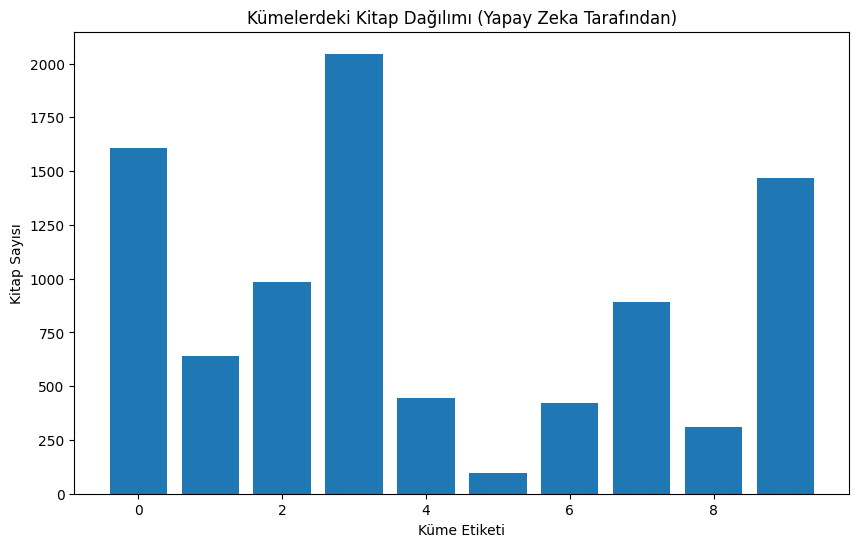


Kümelerdeki Kitap Sayısı:
cluster
0    1607
1     641
2     986
3    2046
4     447
5      97
6     421
7     893
8     308
9    1469
Name: count, dtype: int64


In [58]:
import matplotlib.pyplot as plt

# Kümelerin dağılımını kontrol et
cluster_counts = df['cluster'].value_counts().sort_index()

# Grafik ile küme dağılımını görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel("Küme Etiketi")
plt.ylabel("Kitap Sayısı")
plt.title("Kümelerdeki Kitap Dağılımı (Yapay Zeka Tarafından)")
plt.show()

print("\nKümelerdeki Kitap Sayısı:")
print(cluster_counts)


In [59]:
# Her kümeden ilk 5 kitabı gösteren fonksiyon
def show_cluster_samples(df, num_clusters=10, samples_per_cluster=5):
    print("Kümelerdeki Örnek Kitaplar:\n")
    for cluster_id in range(num_clusters):
        print(f"Küme {cluster_id}:")
        cluster_books = df[df['cluster'] == cluster_id]['title'].head(samples_per_cluster).tolist()
        for book in cluster_books:
            print(f"  - {book}")
        print()

# Küme içeriğini göster
show_cluster_samples(df, num_clusters=10, samples_per_cluster=5)


Kümelerdeki Örnek Kitaplar:

Küme 0:
  - Harry Potter and the Half-Blood Prince (Harry Potter, #6)
  - Harry Potter and the Order of the Phoenix (Harry Potter, #5)
  - Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
  - Harry Potter and the Goblet of Fire (Harry Potter, #4)
  - The Fellowship of the Ring (The Lord of the Rings, #1)

Küme 1:
  - The Second Summer of the Sisterhood (Sisterhood, #2)
  - Messenger (The Giver, #3)
  - The House of the Scorpion (Matteo Alacran, #1)
  - I Am the Messenger
  - Hollywood Hustle (Son of the Mob, #2)

Küme 2:
  - I'm a Stranger Here Myself: Notes on Returning to America after Twenty Years Away
  - The Lost Continent: Travels in Small Town America
  - Notes from a Small Island
  - The Puffin Book Of Nonsense Verse
  - The Broken Wings

Küme 3:
  - Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
  - The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)
  - Dune Messiah (Dune Chronicles #2)
  - Anna Karenin

In [60]:
def explain_ai_recommendation(title, df, kmeans_model, tfidf_matrix):
    if title not in df['title'].values:
        return f"'{title}' kitabı bulunamadı."

    # Kitap indeksini bul ve küme etiketini al
    book_idx = df.index[df['title'] == title].tolist()[0]
    cluster_label = df.loc[book_idx, 'cluster']
    print(f"\nKitap: '{title}'")
    print(f"Yapay Zeka Küme Etiketi: {cluster_label}")

    # Aynı kümedeki kitapları listele
    similar_books = df[df['cluster'] == cluster_label]['title'].tolist()
    similar_books.remove(title)  # Seçilen kitabı çıkar

    print("\nBu kitabın bulunduğu kümedeki diğer kitaplar:")
    for i, book in enumerate(similar_books[:5], 1):
        print(f"{i}. {book}")

# Örnek Kullanım
selected_book = "Harry Potter and the Half-Blood Prince (Harry Potter, #6)"
explain_ai_recommendation(selected_book, df, kmeans, tfidf_matrix)



Kitap: 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)'
Yapay Zeka Küme Etiketi: 0

Bu kitabın bulunduğu kümedeki diğer kitaplar:
1. Harry Potter and the Order of the Phoenix (Harry Potter, #5)
2. Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
3. Harry Potter and the Goblet of Fire (Harry Potter, #4)
4. The Fellowship of the Ring (The Lord of the Rings, #1)
5. A Shadow in Summer (Long Price Quartet, #1)


In [61]:
import pickle

# Modeli pickle ile kaydet
model_path = '/content/drive/MyDrive/kmeans_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model Google Drive'a kaydedildi: {model_path}")


Model Google Drive'a kaydedildi: /content/drive/MyDrive/kmeans_model.pkl


In [62]:
# TF-IDF modelini kaydet
tfidf_path = '/content/drive/MyDrive/tfidf_vectorizer.pkl'
with open(tfidf_path, 'wb') as file:
    pickle.dump(tfidf, file)

print(f"TF-IDF modeli Google Drive'a kaydedildi: {tfidf_path}")


TF-IDF modeli Google Drive'a kaydedildi: /content/drive/MyDrive/tfidf_vectorizer.pkl


In [63]:
# TF-IDF modelini kaydet
label_encoder_path = '/content/drive/MyDrive/label_encoder.pkl'
with open(label_encoder_path, 'wb') as file:
    pickle.dump(label_encoder, file)

print(f"TF-IDF modeli Google Drive'a kaydedildi: {label_encoder_path}")

TF-IDF modeli Google Drive'a kaydedildi: /content/drive/MyDrive/label_encoder.pkl
